## Pseudobulk Tabula Muris

Here, we create the pseudobulk values for the TM from the original single-cell datasets. The single-cell data + annotations can be downloaded here: https://figshare.com/projects/Tabula_Muris_Transcriptomic_characterization_of_20_organs_and_tissues_from_Mus_musculus_at_single_cell_resolution/27733

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix as csr
from scipy.stats import pearsonr
import seaborn as sns
import h5py

### Load relevant datasets FACS

- Limb muscle
- Lung
- Mammary gland
- Marrow
- Spleen

In [2]:
def read_facs(fn, anno_facs):
    '''
    fn = filename of the csv file
    '''
    x = sc.read_csv(fn)
    x = x.transpose()
    gn = x.var_names
    
    #Get annotations
    x.obs['celltype'] = anno_facs['cell_ontology_class']
    
    return x, gn    

In [3]:
# Read annotations
# Remove cells without cell ontology class
anno_facs_all = pd.read_csv('../../TM data/FACS/annotations_facs.csv', usecols=[2,3,21], index_col=0)

idx_remove = anno_facs_all['cell_ontology_class'].isna()
anno_facs_all = anno_facs_all[idx_remove==False]
anno_facs_all.iloc[:5]

,cell_ontology_class,tissue
cell,,
A1.B000610.3_56_F.1.1,bladder cell,Bladder
A1.B002764.3_38_F.1.1,bladder urothelial cell,Bladder
A1.B002771.3_39_F.1.1,bladder cell,Bladder
A1.D041914.3_8_M.1.1,bladder cell,Bladder
A1.D042253.3_9_M.1.1,bladder cell,Bladder


In [4]:
# Create anndata objects for every tissue 
facs_muscle, gn_muscle = read_facs('../../TM data/FACS/FACS/Limb_Muscle-counts.csv', anno_facs_all)
facs_lung, gn_lung = read_facs('../../TM data/FACS/FACS/Lung-counts.csv', anno_facs_all)
facs_gland, gn_gland = read_facs('../../TM data/FACS/FACS/Mammary_Gland-counts.csv', anno_facs_all)
facs_marrow, gn_marrow = read_facs('../../TM data/FACS/FACS/Marrow-counts.csv', anno_facs_all)
facs_spleen, gn_spleen = read_facs('../../TM data/FACS/FACS/Spleen-counts.csv', anno_facs_all)

### Load relevant data 10X

In [5]:
# Some 10X datasets are split into multiple objects --> this makes it a bit harder to match the labels
def read_10x(prefix, anno_droplet, sample):
    counter=0
    files = []
    for file in os.listdir("../../TM data/Droplet/droplet/"):
        if file.startswith(prefix):
            print(file)
            s=np.char.split(np.reshape(file, (1,)), '-')[0][1]
            counter=counter+1
            x_new = sc.read_10x_mtx('../../TM data/Droplet/droplet/' + file)
            
            # Change index of x, remove last four characters of barcode
            obs_new = np.asarray(x_new.obs_names, dtype=str)
            for idx, o in enumerate(x_new.obs_names):
                o_new = o[:-2]
                obs_new[idx] = o_new
            x_new.obs_names = obs_new

            # Find correct barcodes in anno_droplet file
            idx_s = np.isin(sample,s)
            anno_droplet_sub = anno_droplet.iloc[idx_s]
            
            x_new.obs['celltype'] = anno_droplet_sub
                        
            if counter>1:
                x = x.concatenate(x_new, index_unique='-')
            else:
                x = x_new
        
    gn = x.var_names
    
    return x, gn

In [6]:
# Read the annotations
anno_droplet = pd.read_csv('../../TM data/Droplet/annotations_droplet.csv', usecols=[0,1], index_col=0)
anno_split = np.char.split(np.array(anno_droplet.index,dtype=str), '_')
anno_new = np.asarray(anno_droplet.index, dtype=str)
sample = np.zeros((len(anno_droplet)), dtype='<U30')

for idx in range(len(anno_droplet.index)):
    anno_new[idx] = anno_split[idx][-1]
    sample[idx] = str.join('_', anno_split[idx][0:3])

anno_droplet.index = anno_new


In [7]:
# Create anndata objects for every tissue
drop_muscle, gn_drop_muscle = read_10x('Limb', anno_droplet, sample)
drop_lung, gn_drop_lung = read_10x('Lung', anno_droplet, sample)
drop_gland, gn_drop_gland = read_10x('Mammary', anno_droplet, sample)
drop_marrow, gn_drop_marrow = read_10x('Marrow', anno_droplet, sample)
drop_spleen, gn_drop_spleen = read_10x('Spleen', anno_droplet, sample)

Limb_Muscle-10X_P7_14
Limb_Muscle-10X_P7_15
Lung-10X_P7_8
Lung-10X_P7_9
Lung-10X_P8_12
Lung-10X_P8_13
Mammary_Gland-10X_P7_12
Mammary_Gland-10X_P7_13
Marrow-10X_P7_2
Marrow-10X_P7_3
Spleen-10X_P4_7
Spleen-10X_P7_6


#### Ensure same gene order

In [8]:
# Read gene names with TSS
hf = h5py.File('../../Zenodo/mouse/mouse_seq_hl.h5', 'r', libver='latest', swmr=True)
gn = np.asarray(hf['geneName']).astype('U30')
hf.close()

In [9]:
facs_gland = facs_gland[:, gn]
facs_muscle = facs_muscle[:, gn]
facs_marrow = facs_marrow[:, gn]
facs_lung = facs_lung[:, gn]
facs_spleen = facs_spleen[:, gn]

In [10]:
drop_gland = drop_gland[:, gn]
drop_muscle = drop_muscle[:, gn]
drop_marrow = drop_marrow[:, gn]
drop_lung = drop_lung[:, gn]
drop_spleen = drop_spleen[:, gn]

C:\Users\lcmmichielsen\Anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### Create pseudobulk labels

Here, we will generate labels with and without pseudocount. The labels without pseudocount look more like a normal distribution and are therefore easier to use when training the model.

In [11]:
def create_labels_withoutpseudo(adata, tissue):
    
    ct = np.unique(np.array(adata.obs['celltype'], dtype=str))
    if np.isin('nan', ct):
        num_col = len(ct)
        ct = ct[ct != 'nan']
    else:
        num_col = len(ct)+1
    
    # Pseudobulk over whole tissue
    logmean=pd.DataFrame(data=np.zeros((np.shape(adata)[1], num_col)),
                         index=adata.var_names,
                         columns=np.concatenate((['All'], ct)))
    
    mn = np.asarray(np.mean(adata.X, axis=0)).reshape((-1,))
    idx = mn != 0
    mn[idx] = np.log10(mn[idx])
    mn[~idx] = -4 # Replace genes with 0 expression with -4
    logmean['All'] = mn
    
    # Pseudobulk per cell population
    for cp in np.unique(np.array(adata.obs['celltype'],dtype=str)):
        if cp != 'nan':

            idx = adata.obs['celltype'] == cp
            sub = adata[idx]

            mn = np.asarray(np.mean(sub.X, axis=0)).reshape((-1,))
            idx = mn != 0
            mn[idx] = np.log10(mn[idx])
            mn[~idx] = -4
            logmean[cp] = mn
    
    # Plot the results
    x = pd.melt(logmean)

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    palette = sns.color_palette("Set2", 12)
    g = sns.FacetGrid(x, palette=palette, row='variable', hue='variable', aspect=6, height=1.5)
    g.map_dataframe(sns.kdeplot, gridsize=100, bw_adjust=0.1, x='value', fill=True, alpha=1)
    g.map_dataframe(sns.kdeplot, gridsize=100, bw_adjust=0.1, x='value', color='black')

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0.92, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, 'variable')
    g.fig.subplots_adjust(hspace=-.4)
    g.set_titles("")
    g.set(yticks=[], xlabel='Expression', ylabel='')
    g.despine(left=True)
    plt.suptitle(tissue, y=0.98)
    plt.show()
        
    return logmean

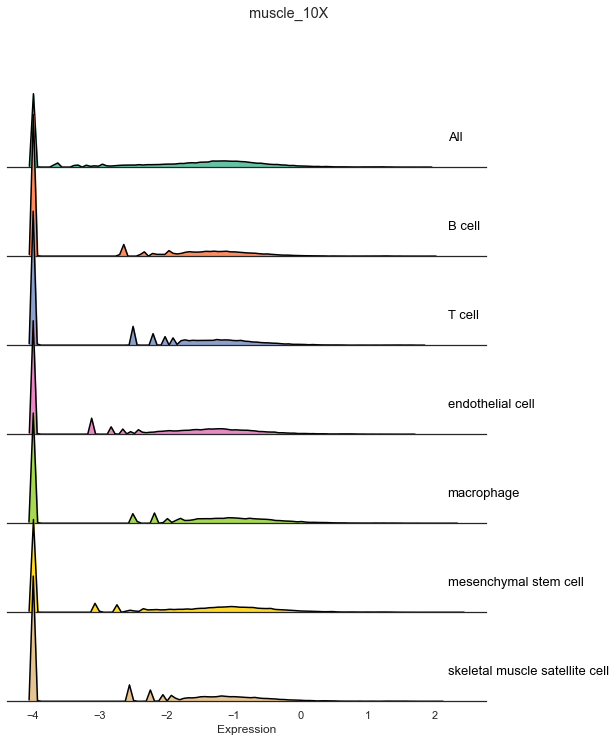

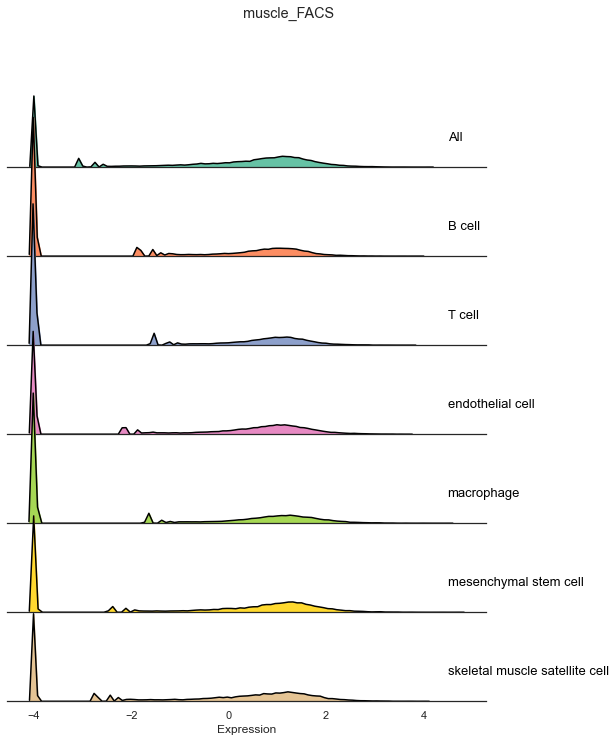

C:\Users\lcmmichielsen\Anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


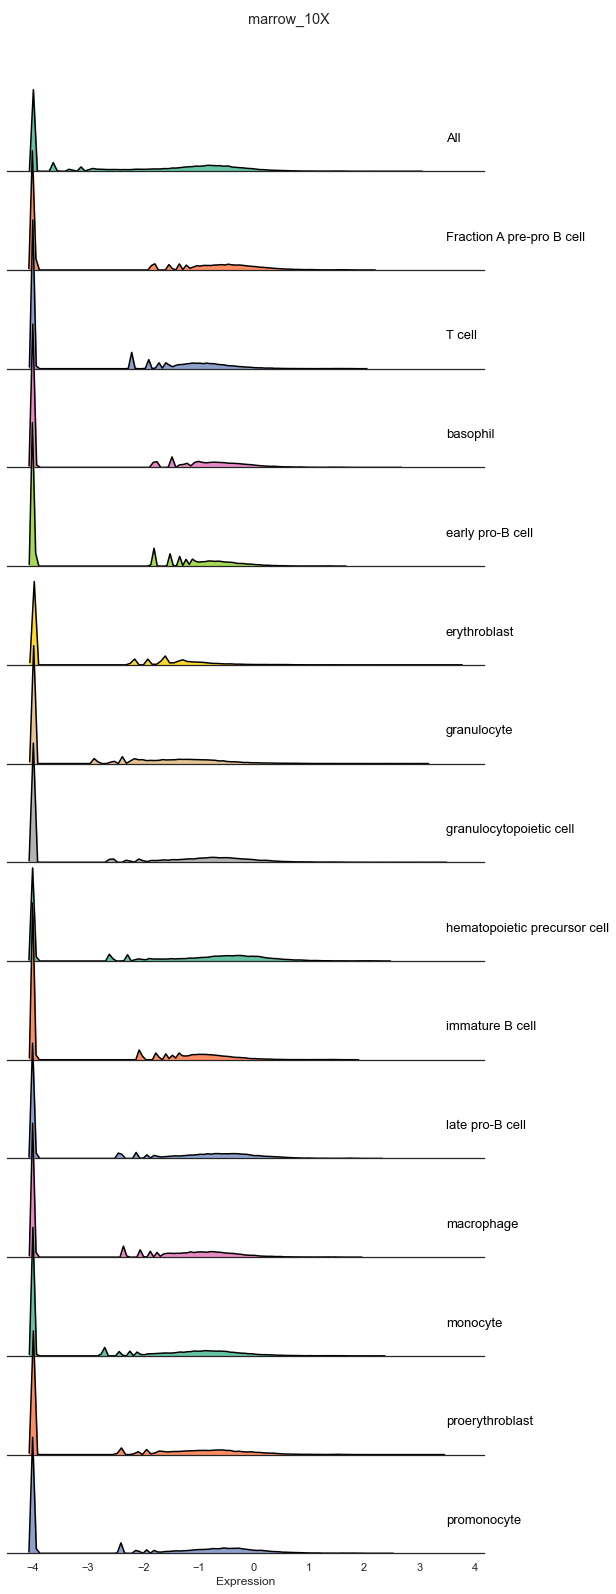

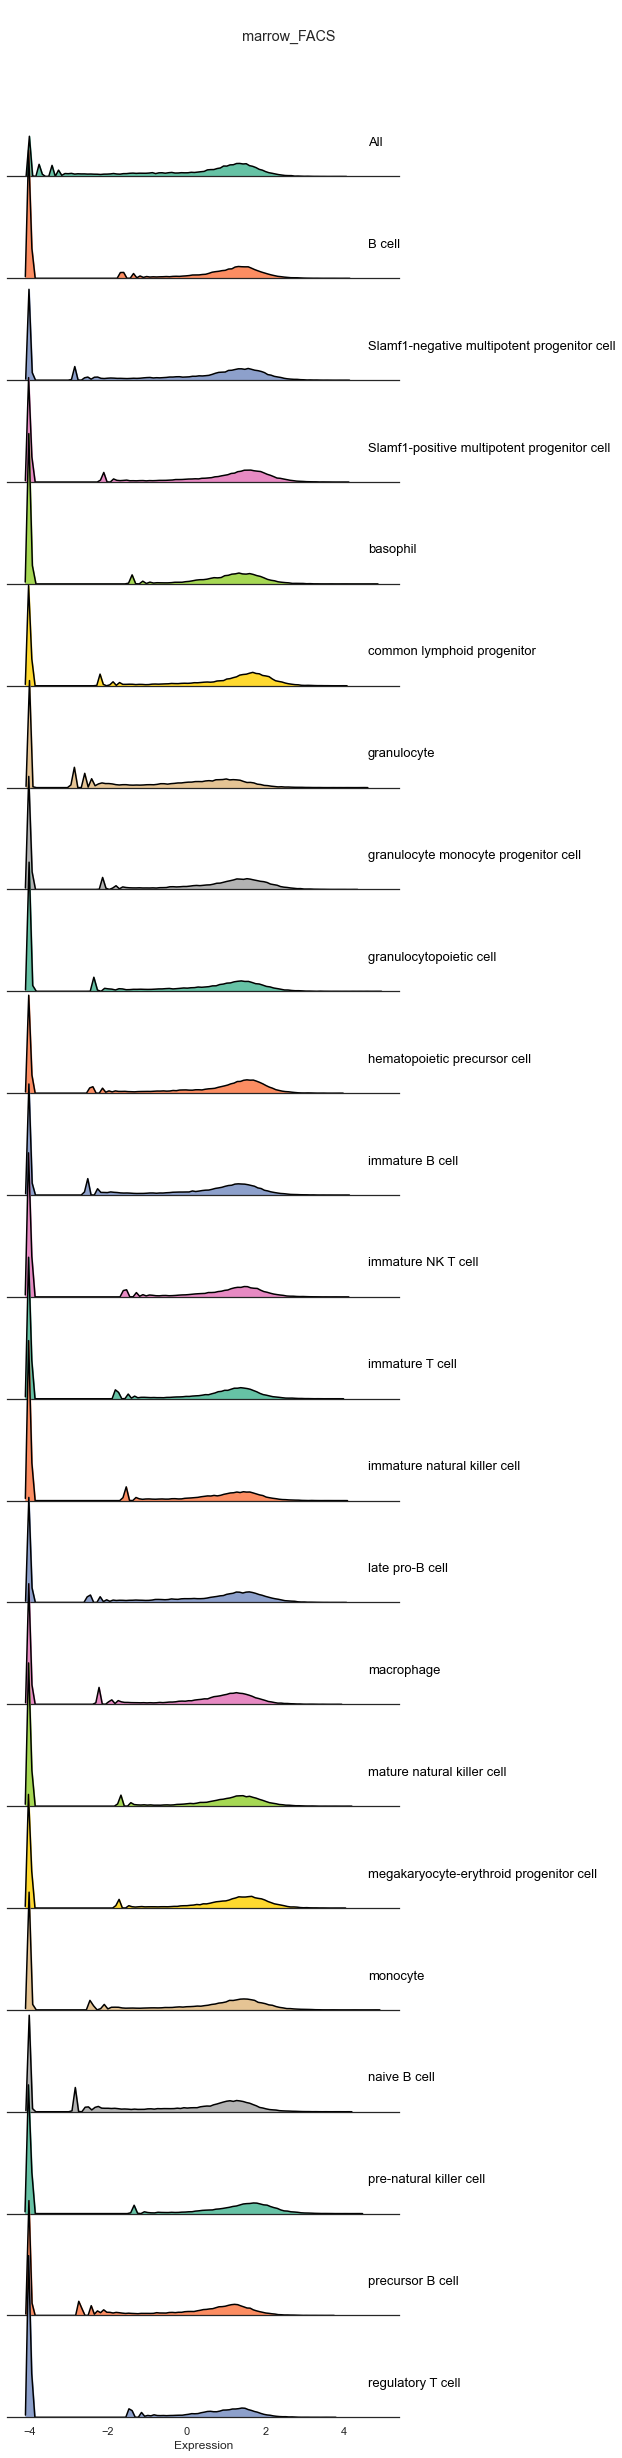

C:\Users\lcmmichielsen\Anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


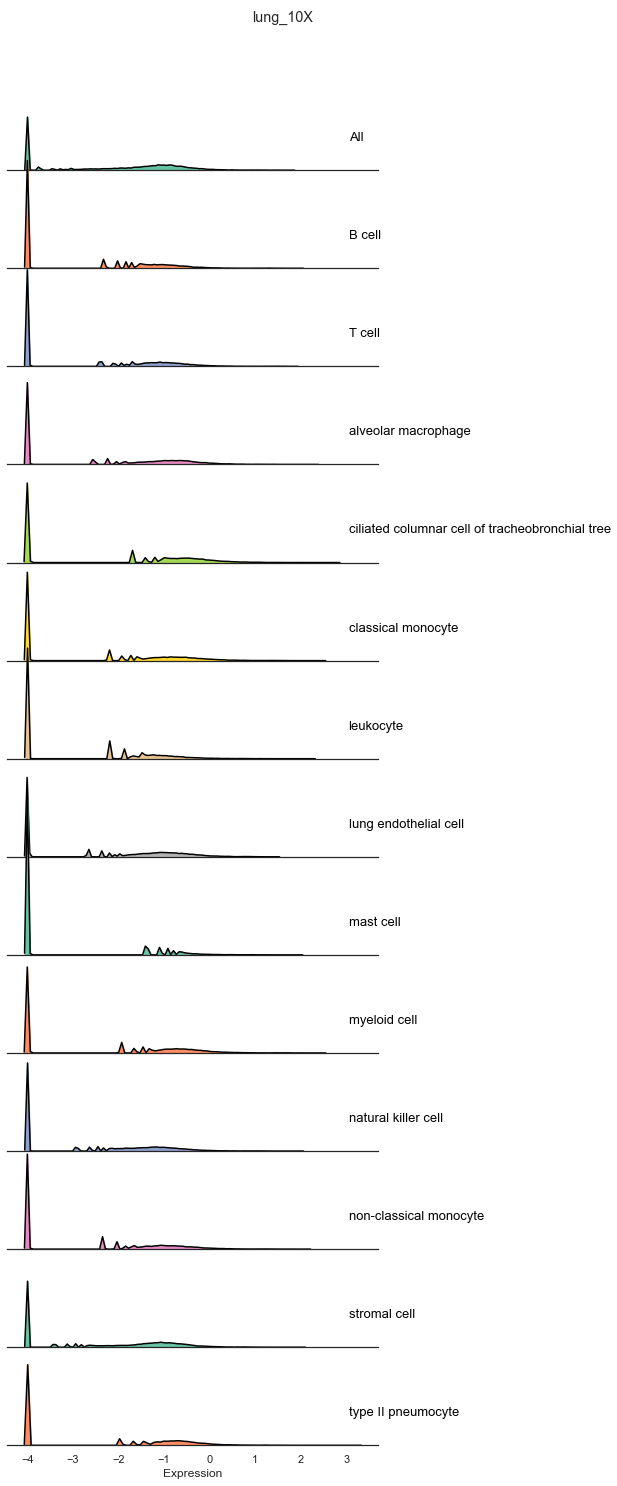

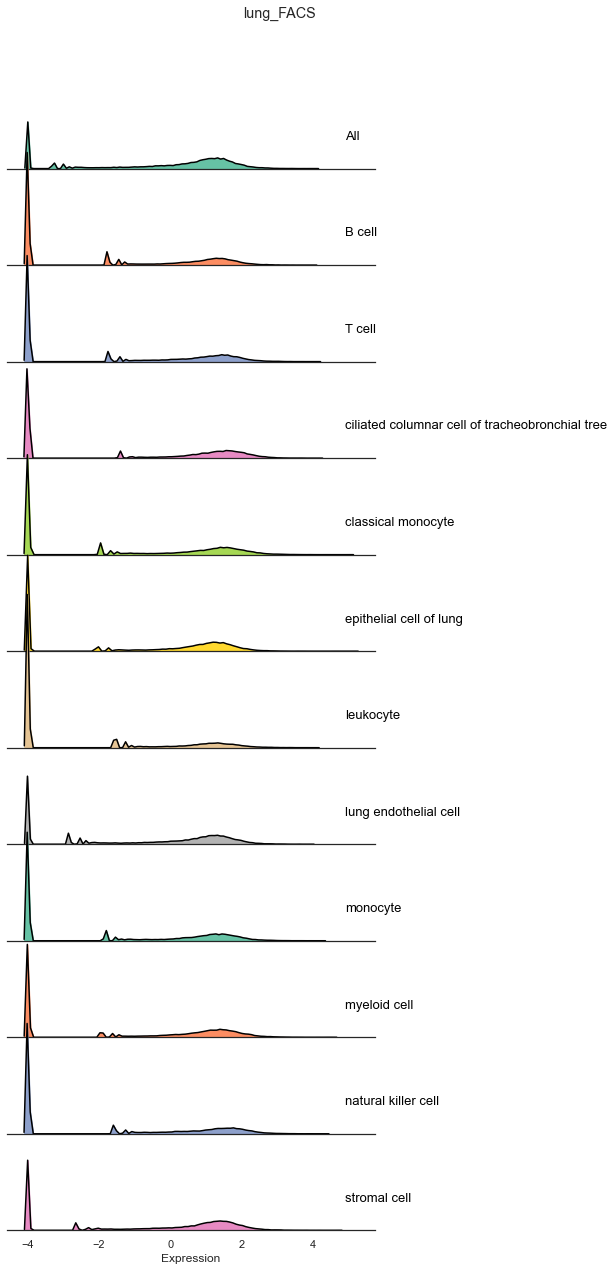

C:\Users\lcmmichielsen\Anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


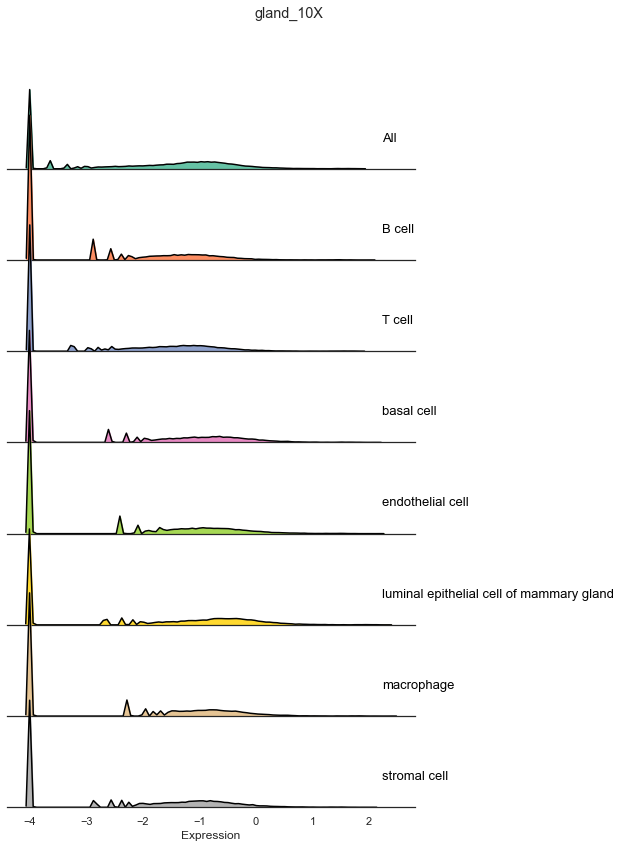

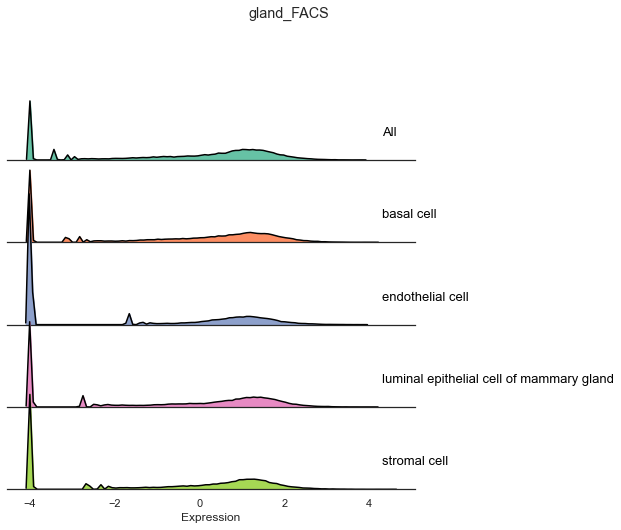

C:\Users\lcmmichielsen\Anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


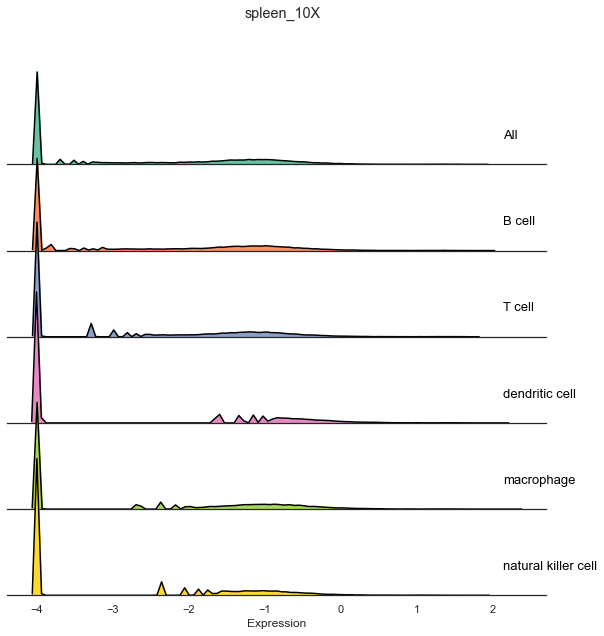

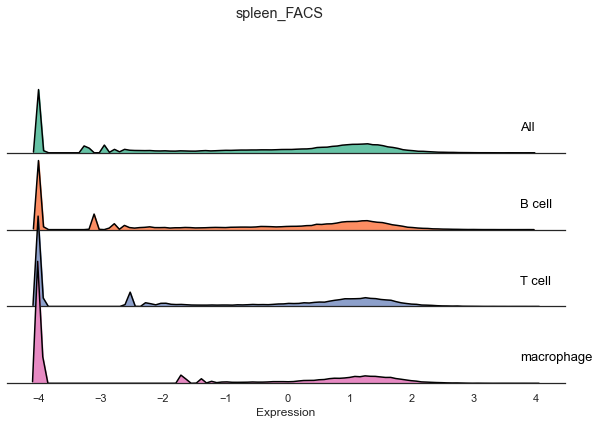

In [12]:
x_drop_muscle = create_labels_withoutpseudo(drop_muscle, 'muscle_10X')
x_facs_muscle = create_labels_withoutpseudo(facs_muscle, 'muscle_FACS')

x_drop_marrow = create_labels_withoutpseudo(drop_marrow, 'marrow_10X')
x_facs_marrow = create_labels_withoutpseudo(facs_marrow, 'marrow_FACS')

drop_lung = drop_lung[~drop_lung.obs['celltype'].isna()] # Lot of cells not annotated --> remove these
x_drop_lung = create_labels_withoutpseudo(drop_lung, 'lung_10X')
x_facs_lung = create_labels_withoutpseudo(facs_lung, 'lung_FACS')

x_drop_gland = create_labels_withoutpseudo(drop_gland, 'gland_10X')
x_facs_gland = create_labels_withoutpseudo(facs_gland, 'gland_FACS')

x_drop_spleen = create_labels_withoutpseudo(drop_spleen, 'spleen_10X')
x_facs_spleen = create_labels_withoutpseudo(facs_spleen, 'spleen_FACS')



In [13]:
def create_labels_withpseudo(adata, tissue):
    
    ct = np.unique(np.array(adata.obs['celltype'], dtype=str))
    if np.isin('nan', ct):
        num_col = len(ct)
        ct = ct[ct != 'nan']
    else:
        num_col = len(ct)+1
    
    # Pseudobulk over whole tissue
    logmean=pd.DataFrame(data=np.zeros((np.shape(adata)[1], num_col)),
                         index=adata.var_names,
                         columns=np.concatenate((['All'], ct)))
    
    mn = np.asarray(np.mean(adata.X, axis=0)).reshape((-1,))
    logmean['All'] = np.log10(mn+1)
    
    # Pseudobulk per cell population
    for cp in np.unique(np.array(adata.obs['celltype'],dtype=str)):
        if cp != 'nan':

            idx = adata.obs['celltype'] == cp
            sub = adata[idx]

            mn = np.asarray(np.mean(sub.X, axis=0)).reshape((-1,))
            logmean[cp] = np.log10(mn+1)
    
    # Plot the results
    x = pd.melt(logmean)

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    palette = sns.color_palette("Set2", 12)
    g = sns.FacetGrid(x, palette=palette, row='variable', hue='variable', aspect=6, height=1.5)
    g.map_dataframe(sns.kdeplot, gridsize=100, bw_adjust=0.1, x='value', fill=True, alpha=1)
    g.map_dataframe(sns.kdeplot, gridsize=100, bw_adjust=0.1, x='value', color='black')

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0.92, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, 'variable')
    g.fig.subplots_adjust(hspace=-.4)
    g.set_titles("")
    g.set(yticks=[], xlabel='Expression', ylabel='')
    g.despine(left=True)
    plt.suptitle(tissue, y=0.98)
    plt.show()
        
    return logmean

C:\Users\lcmmichielsen\Anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


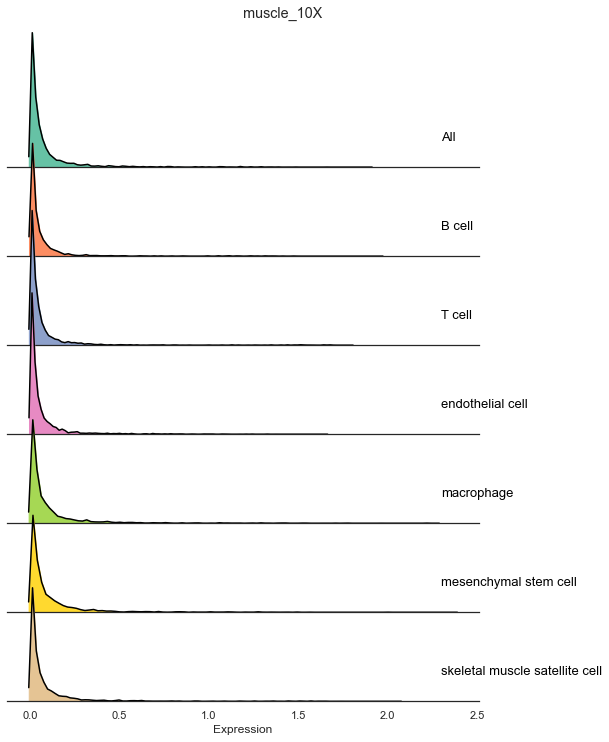

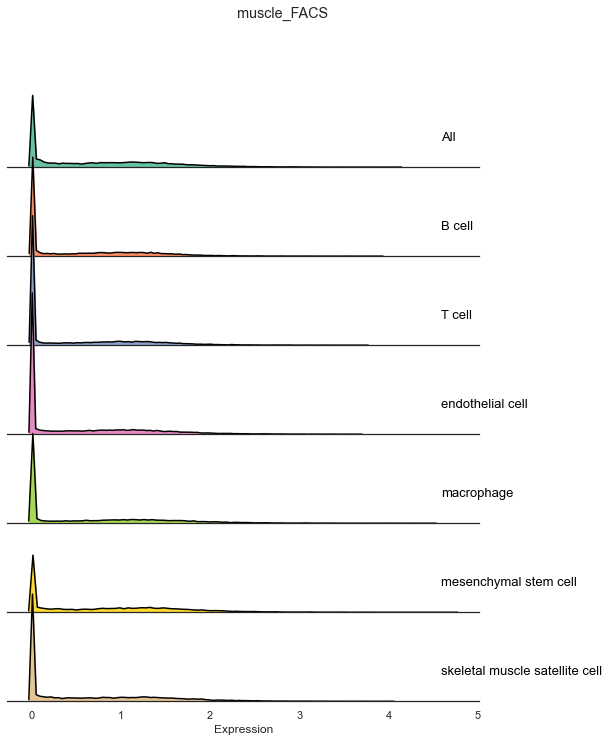

C:\Users\lcmmichielsen\Anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


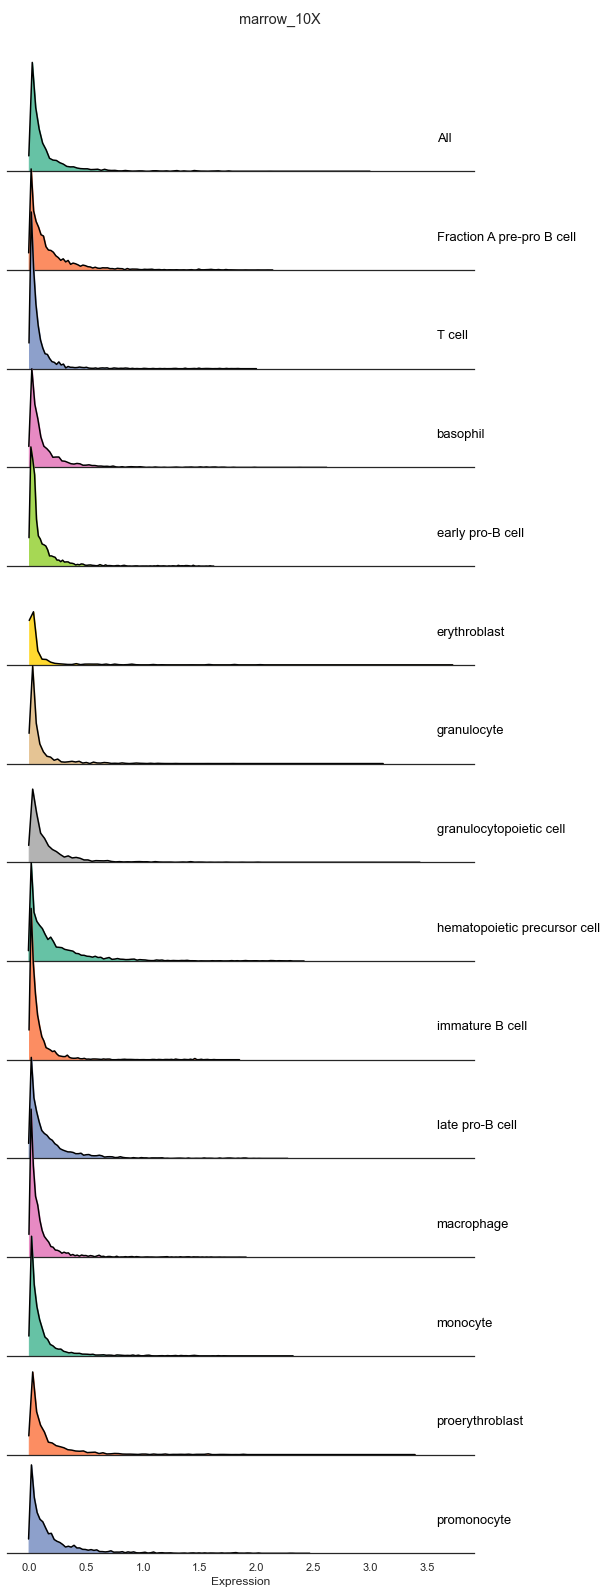

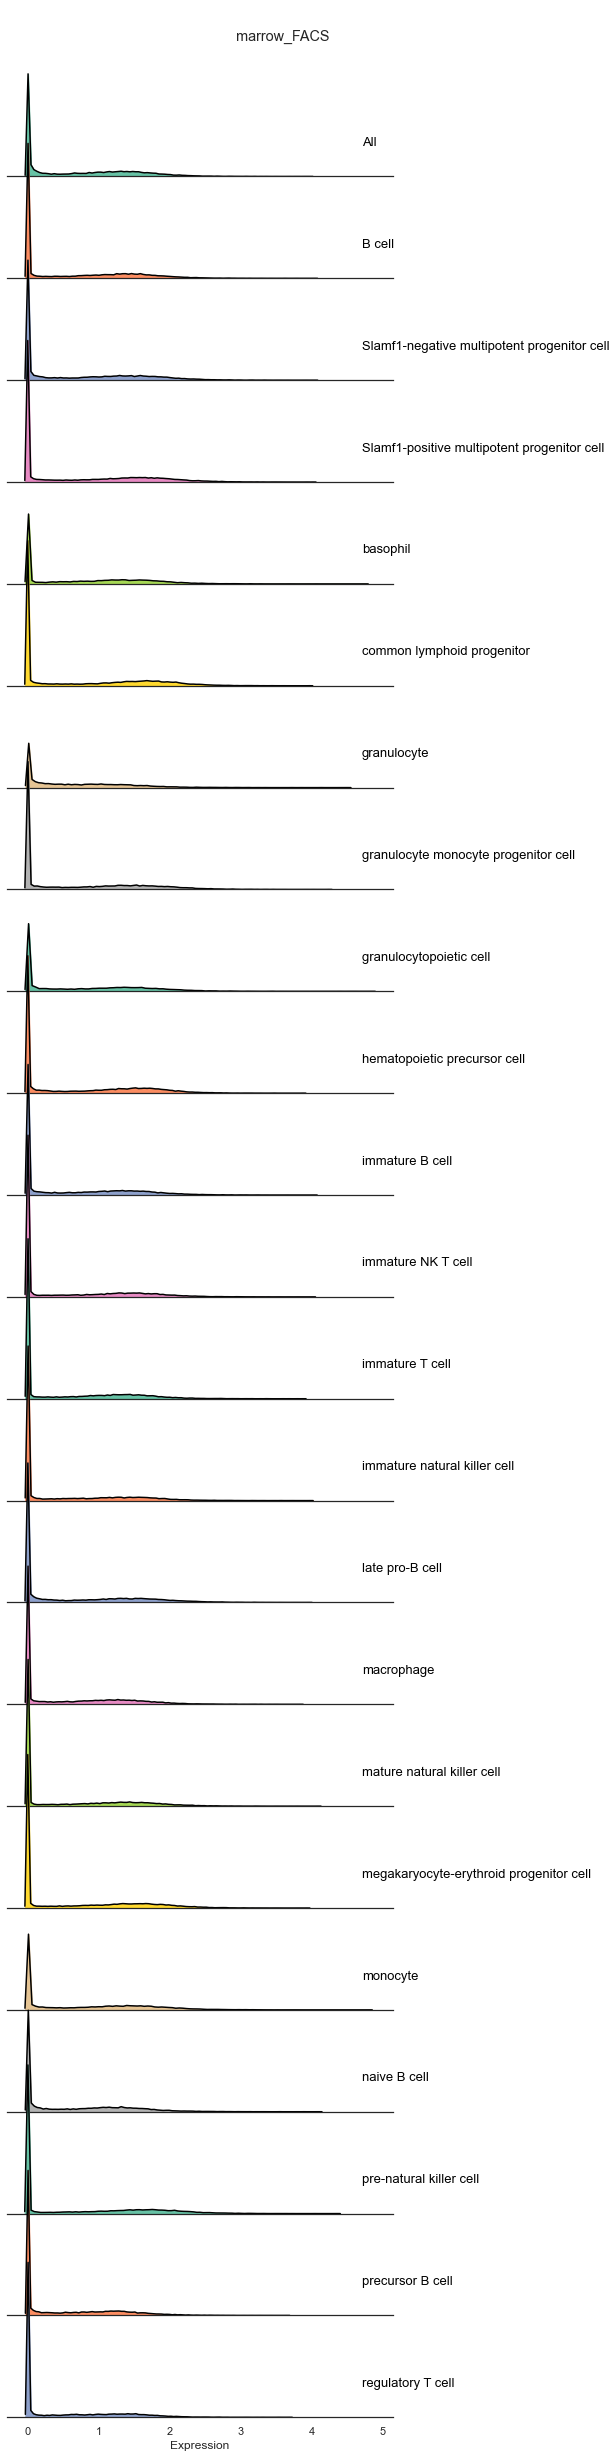

C:\Users\lcmmichielsen\Anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


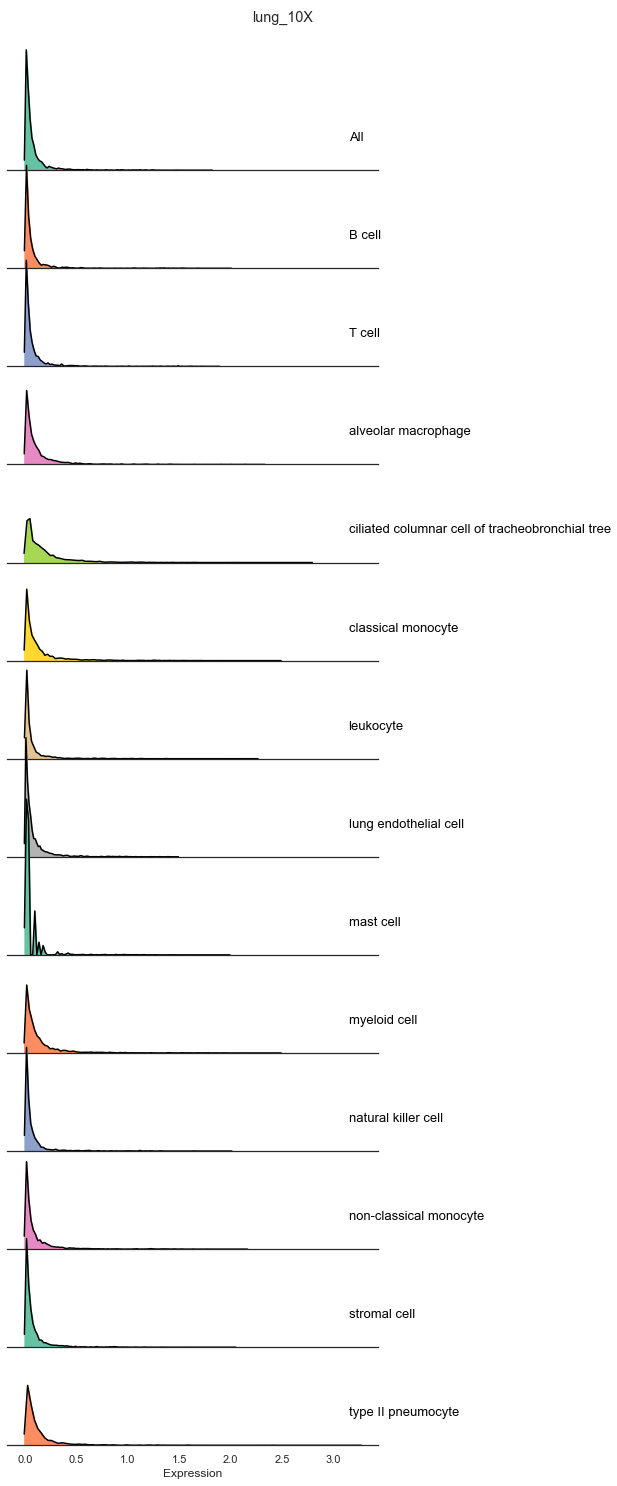

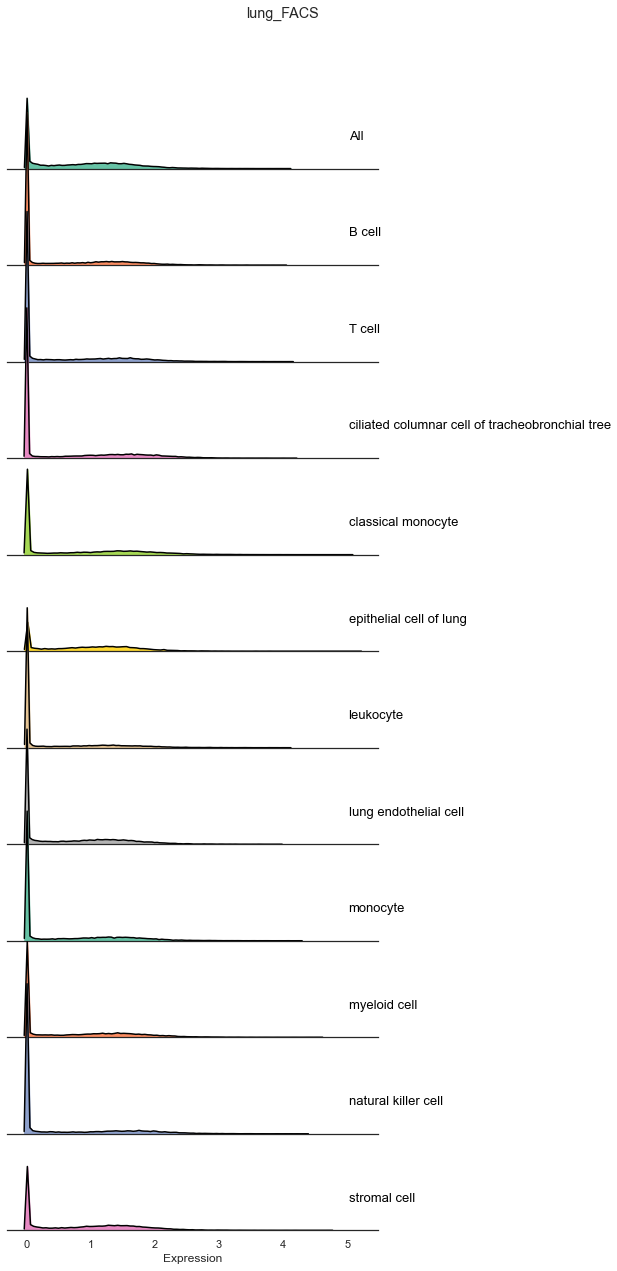

C:\Users\lcmmichielsen\Anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


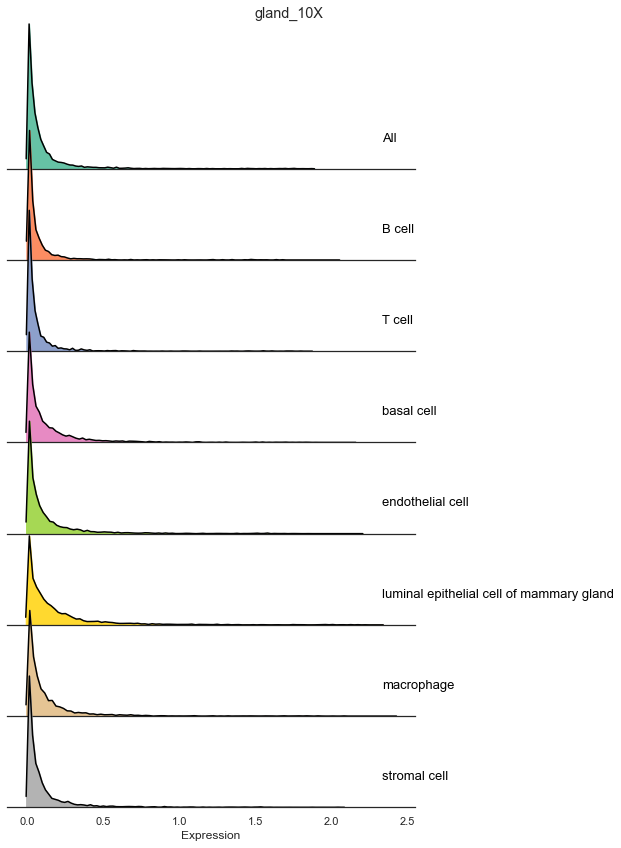

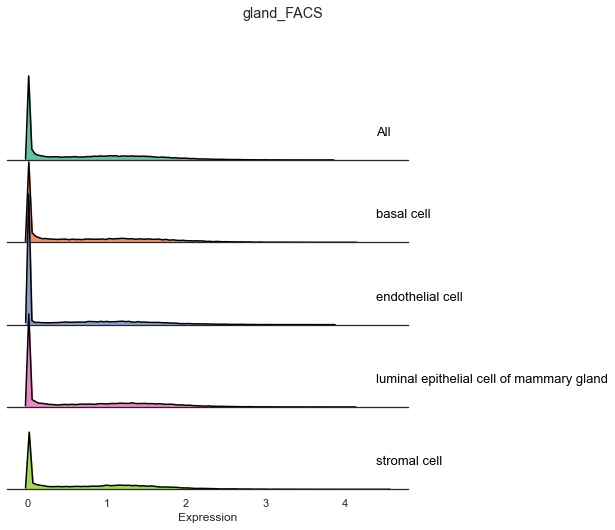

C:\Users\lcmmichielsen\Anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


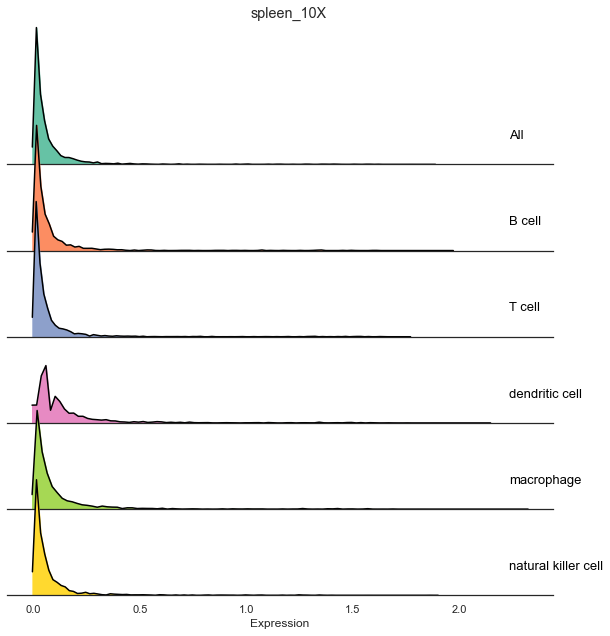

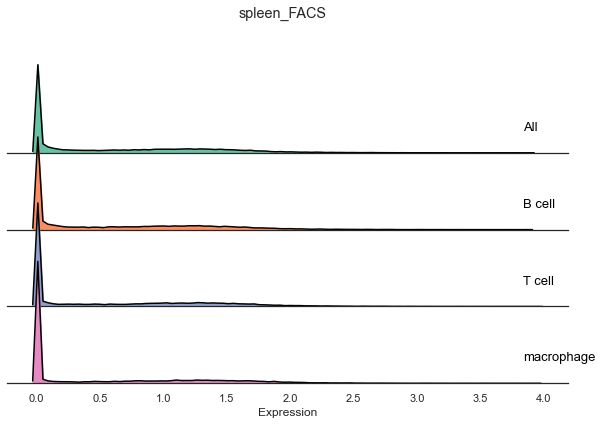

In [14]:
x_drop_muscle = create_labels_withpseudo(drop_muscle, 'muscle_10X')
x_facs_muscle = create_labels_withpseudo(facs_muscle, 'muscle_FACS')

x_drop_marrow = create_labels_withpseudo(drop_marrow, 'marrow_10X')
x_facs_marrow = create_labels_withpseudo(facs_marrow, 'marrow_FACS')

drop_lung = drop_lung[~drop_lung.obs['celltype'].isna()] # Lot of cells not annotated --> remove these
x_drop_lung = create_labels_withpseudo(drop_lung, 'lung_10X')
x_facs_lung = create_labels_withpseudo(facs_lung, 'lung_FACS')

x_drop_gland = create_labels_withpseudo(drop_gland, 'gland_10X')
x_facs_gland = create_labels_withpseudo(facs_gland, 'gland_FACS')

x_drop_spleen = create_labels_withpseudo(drop_spleen, 'spleen_10X')
x_facs_spleen = create_labels_withpseudo(facs_spleen, 'spleen_FACS')

